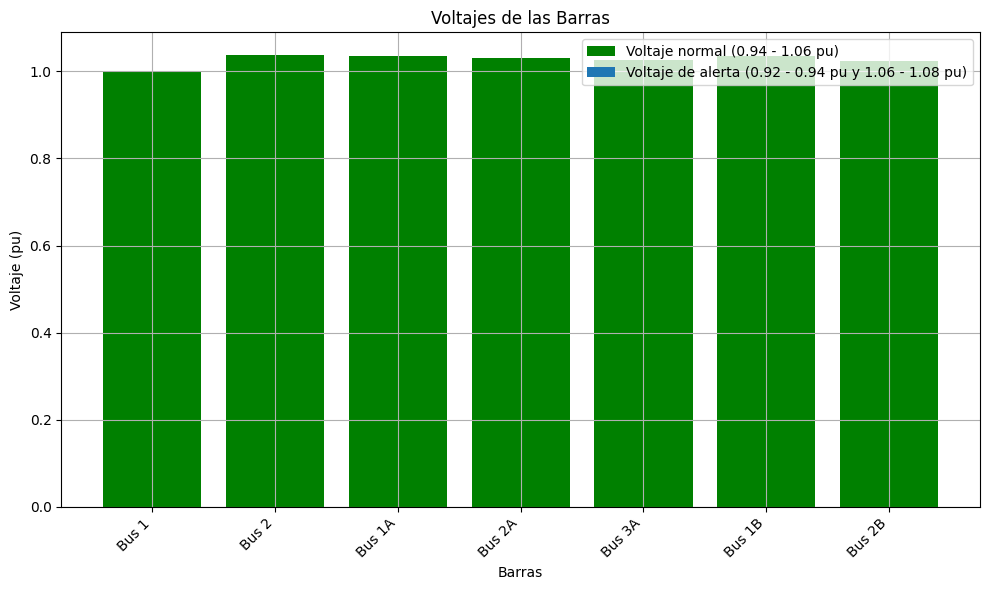

Barra 1     1.000000 => 1.000000
Barra 2     1.033380 => 1.038014
Barra 1a    1.031457 => 1.034785
Barra 2a    1.029237 => 1.030587
Barra 3a    1.028365 => 1.027060
Barra 1b    1.032375 => 1.035038
Barra 2b    1.027435 => 1.024142
Esto se logró con una compensación inductiva serie en la barra 2b y con una compensación shunt capacitiva en la barra 2, lo que consiguió aumentar la  tensión en esta y bajarla en la barra 2b
Cuando haya un voltaje mayor del necesario se necesitaría una compensación inductiva serie para bajar el voltaje, lo que se conseguiría creando un elemento shunt que simule la compensación inductiva. En cambio, si existiera un valor de voltaje menor al necesario para que se considerara dentro de norma se necesitaría uncluir una compensación Shunt capacitiva.


In [3]:
# %%
import pandapower as pp
import pandapower.plotting as plot
import matplotlib.pyplot as plt

# Crear la red de ejemplo
net = pp.create_empty_network()

# Crear barras
bus1 = pp.create_bus(net, vn_kv=110, name="Bus 1")
bus2 = pp.create_bus(net, vn_kv=220, name="Bus 2")
bus1a = pp.create_bus(net, vn_kv=220, name="Bus 1A")
bus2a = pp.create_bus(net, vn_kv=220, name="Bus 2A")
bus3a = pp.create_bus(net, vn_kv=220, name="Bus 3A")
bus1b = pp.create_bus(net, vn_kv=220, name="Bus 1B")
bus2b = pp.create_bus(net, vn_kv=220, name="Bus 2B")

# Crear las líneas de transmisión
pp.create_line(net, from_bus=bus2, to_bus=bus1a, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Linea 2-1A")
pp.create_line(net, from_bus=bus1a, to_bus=bus2a, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Linea 1A-2A")
pp.create_line(net, from_bus=bus2a, to_bus=bus3a, length_km=20, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Linea 2A-3A")
pp.create_line(net, from_bus=bus3a, to_bus=bus2b, length_km=15, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Linea 3A-2B")
pp.create_line(net, from_bus=bus2, to_bus=bus1b, length_km=10, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Linea 2-1B")
pp.create_line(net, from_bus=bus1b, to_bus=bus2b, length_km=30, std_type="N2XS(FL)2Y 1x185 RM/35 64/110 kV", name="Linea 1B-2B")

# Crear un transformador
pp.create_transformer(net, hv_bus=bus2, lv_bus=bus1, std_type="100 MVA 220/110 kV", name="Trafo 1-2")

# Crear una barra slack
pp.create_ext_grid(net, bus=bus1, vm_pu=1.0)

# Definir la carga nominal para todas las barras
p_nominal = 150  # MW
q_nominal = 100  # MVAr

# Cargas para cada barra 
pp.create_load(net, bus=bus1a, p_mw=p_nominal*0.2, q_mvar=q_nominal*0.2, name="Load 1A")
pp.create_load(net, bus=bus2a, p_mw=p_nominal*0.35, q_mvar=q_nominal*0.35, name="Load 2A")
pp.create_load(net, bus=bus3a, p_mw=p_nominal*0.15, q_mvar=q_nominal*0.15, name="Load 3A")
pp.create_load(net, bus=bus1b, p_mw=p_nominal*0.1, q_mvar=q_nominal*0.1, name="Load 1B")
pp.create_load(net, bus=bus2b, p_mw=p_nominal*0.6, q_mvar=q_nominal*0.6, name="Load 2B")

# Simular compensaciones en barra 2 y barra 2B
pp.create_shunt(net, bus=bus2, q_mvar=-101.59, p_mw=0, name="Shunt Capacitor at Bus 1A")
pp.create_shunt(net, bus=bus2b, q_mvar=-1/(-0.001 * net.line.loc[net.line.index[0], 'length_km']), p_mw=0, name="Compensacion Serie Inductiva")

# Ejecutar flujo de carga
pp.runpp(net)

# Obtener resultados de voltajes de las barras
bus_voltages = net.res_bus.vm_pu

# Clasificar los voltajes
acceptable_voltages = bus_voltages[(bus_voltages >= 0.94) & (bus_voltages <= 1.06)]
unacceptable_voltages = bus_voltages[((bus_voltages >= 0.92) & (bus_voltages < 0.94)) | ((bus_voltages > 1.06) & (bus_voltages <= 1.08))]

# Crear un gráfico para visualizar los voltajes de las barras
plt.figure(figsize=(10, 6))

plt.bar(acceptable_voltages.index, acceptable_voltages, color='green', label='Voltaje normal (0.94 - 1.06 pu)')
plt.bar(unacceptable_voltages.index, unacceptable_voltages, color='red', label='Voltaje de alerta (0.92 - 0.94 pu y 1.06 - 1.08 pu)')

bus_names = net.bus.name.tolist()
plt.xticks(ticks=bus_voltages.index, labels=bus_names, rotation=45, ha='right')
plt.xlabel('Barras')
plt.ylabel('Voltaje (pu)')
plt.title('Voltajes de las Barras')
plt.legend()
plt.grid(True)
plt.tight_layout()  # Para ajustar el layout y evitar superposición de etiquetas
plt.show()
print("Barra 1     1.000000 => 1.000000")
print("Barra 2     1.033380 => 1.038014")
print("Barra 1a    1.031457 => 1.034785")
print("Barra 2a    1.029237 => 1.030587")
print("Barra 3a    1.028365 => 1.027060")
print("Barra 1b    1.032375 => 1.035038")
print("Barra 2b    1.027435 => 1.024142")
print("Esto se logró con una compensación inductiva serie en la barra 2b y con una compensación shunt capacitiva en la barra 2, lo que consiguió aumentar la  tensión en esta y bajarla en la barra 2b")
print("Cuando haya un voltaje mayor del necesario se necesitaría una compensación inductiva serie para bajar el voltaje, lo que se conseguiría creando un elemento shunt que simule la compensación inductiva. En cambio, si existiera un valor de voltaje menor al necesario para que se considerara dentro de norma se necesitaría uncluir una compensación Shunt capacitiva.")